<a href="https://colab.research.google.com/github/stxupengyu/NCF-MF-for-Recommendation/blob/main/yelp_nn_recomendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Link Google Drive

In [ ]:
#link google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#enter the folder
!ls
import os
os.chdir('/content/drive/My Drive/Project/Deep-Rec-Sys')
!ls

best_model.h5			     yelp_academic_dataset_review.json
Dataset_Agreement.pdf		     yelp_academic_dataset_tip.json
kaggle.json			     yelp_academic_dataset_user.json
rating.csv			     yelp_data_analysis.ipynb
rating_text.csv			     yelp_mf_recomendation.ipynb
yelp_academic_dataset_business.json  yelp_nn_recomendation.ipynb
yelp_academic_dataset_checkin.json   yelp_nn_recomendation.ipynb（副本）
best_model.h5			     yelp_academic_dataset_review.json
Dataset_Agreement.pdf		     yelp_academic_dataset_tip.json
kaggle.json			     yelp_academic_dataset_user.json
rating.csv			     yelp_data_analysis.ipynb
rating_text.csv			     yelp_mf_recomendation.ipynb
yelp_academic_dataset_business.json  yelp_nn_recomendation.ipynb
yelp_academic_dataset_checkin.json   yelp_nn_recomendation.ipynb（副本）


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data=pd.read_csv('rating_text.csv')
display(data.tail(2))

,user_id,business_id,stars,text
71008,24585,3526,5.0,I was looking for hairdressers to go to becaus...
71009,10713,3527,5.0,I'm so pleased to have stumbled across this ut...


In [ ]:
n_users, n_rests, max_rating = data.iloc[:,:3].max()
min_rating = data.iloc[:,2].min()
n_factors = 1000

In [ ]:
from sklearn.model_selection import train_test_split

X = data[['user_id', 'business_id']].values
y = data['stars'].values

X_train_keras, X_test_keras, y_train_keras, y_test_keras = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_keras.shape, X_test_keras.shape, y_train_keras.shape, y_test_keras.shape

((56808, 2), (14202, 2), (56808,), (14202,))

In [ ]:
X_train_array = [X_train_keras[:, 0], X_train_keras[:, 1]]
X_test_array = [X_test_keras[:, 0], X_test_keras[:, 1]]

In [ ]:
from keras.layers import Add, Activation, Lambda
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        
        return x
    
def Recommender(n_users, n_rests, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    restaurant = Input(shape=(1,))
    m = EmbeddingLayer(n_rests, n_factors)(restaurant)
    mb = EmbeddingLayer(n_rests, 1)(restaurant)   
    
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)  
    
    model = Model(inputs=[user, restaurant], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae','mse'])  
    
    return model

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint, EarlyStopping

#保存最好的模型
model_name='best_model.h5'
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath=model_name, monitor='val_loss', save_best_only=True)
keras_model = Recommender(int(n_users)+1, int(n_rests)+1, n_factors, min_rating, max_rating)
keras_model.summary()
history = keras_model.fit(x=X_train_array, y=y_train_keras, batch_size=64,\
      epochs=150, verbose=1, callbacks=[es, cp], validation_data=(X_test_array, y_test_keras))


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 1000)      35091000    input_5[0][0]                    
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 1000)      3528000     input_6[0][0]                    
_______________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


888/888 [==============================] - 216s 244ms/step - loss: 2.0616 - mae: 1.2506 - mse: 2.0553 - val_loss: 1.9573 - val_mae: 1.2217 - val_mse: 1.9434
Epoch 2/150
888/888 [==============================] - 218s 245ms/step - loss: 0.7149 - mae: 0.6462 - mse: 0.6850 - val_loss: 1.9319 - val_mae: 1.1933 - val_mse: 1.8862
Epoch 3/150
888/888 [==============================] - 218s 245ms/step - loss: 0.2764 - mae: 0.3627 - mse: 0.2302 - val_loss: 1.9105 - val_mae: 1.1856 - val_mse: 1.8623
Epoch 4/150
888/888 [==============================] - 215s 242ms/step - loss: 0.2424 - mae: 0.3350 - mse: 0.1910 - val_loss: 1.9136 - val_mae: 1.1825 - val_mse: 1.8580
Epoch 5/150
888/888 [==============================] - 217s 244ms/step - loss: 0.2235 - mae: 0.3201 - mse: 0.1687 - val_loss: 1.8910 - val_mae: 1.1739 - val_mse: 1.8346
Epoch 6/150
888/888 [==============================] - 215s 242ms/step - loss: 0.2162 - mae: 0.3036 - mse: 0.1584 - val_loss: 1.8916 - val_mae: 1.1718 - val_mse: 1.830

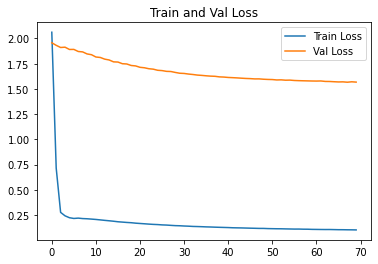

mae,rmse: 1.0172914561461839 1.2329574922800597


In [ ]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()
# 加载最好的训练结果
keras_model.load_weights(model_name)  
y_pred = keras_model.predict(X_test_array)
mae = mean_absolute_error(y_test_keras, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_keras, y_pred))
print('mae,rmse:',mae,rmse)